In [15]:
#NRM,---Abstract-Target-Code-Solved-Improve--- Copyright:Geovawe
#This code to resample tracklog coordinate overtime to produce XY coordinate to embed with SEGY file (give time-coordinate interpolated exact position of each trace).

In [16]:
import pandas as pd

In [432]:
import segyio
f = segyio.open(r"C:\Users\OMEN\Documents\DS\F2 S-U_0001_B1.SGY",mode="r+") #Path to Segy file that you want to embed the Coordinate

In [119]:
filepath="D:\GPR CIKADAL\PADALARANG\COOR\F2.txt" #Path to txt exported track of Garmin GPS by Mapsource, you must use UTM Projection.
my_cols = [str(i) for i in range(20)] # create some dummy row names

In [134]:
gps=pd.read_csv(filepath,sep="\s+|\t",names=my_cols,header=None,skiprows=8,engine="python")

In [141]:
gps.head() #we know 3 was X and 4 was Y and 6 is time sampled.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Trackpoint,48,M,768535,9248271,04/05/2020,12:24:05,490,m,NaN,None,None,NaN,None,None,None,NaN,NaN,NaN,NaN
1,Trackpoint,48,M,768537,9248274,04/05/2020,12:24:16,489,m,4.0,m,0:00:11,1.2,kph,18°,true,NaN,NaN,NaN,NaN
2,Trackpoint,48,M,768539,9248280,04/05/2020,12:24:26,490,m,6.0,m,0:00:10,2.0,kph,20°,true,NaN,NaN,NaN,NaN
3,Trackpoint,48,M,768541,9248287,04/05/2020,12:24:36,490,m,7.0,m,0:00:10,3.0,kph,18°,true,NaN,NaN,NaN,NaN
4,Trackpoint,48,M,768544,9248293,04/05/2020,12:24:46,489,m,6.0,m,0:00:10,2.0,kph,24°,true,NaN,NaN,NaN,NaN


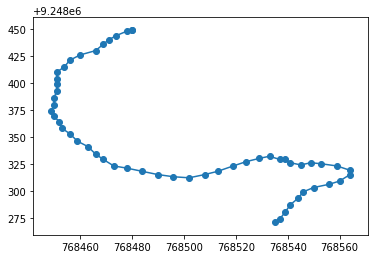

In [154]:
import matplotlib.pyplot as plt

plt.plot(gps['3'],gps['4'])
plt.scatter(gps['3'],gps['4'])
plt.show()
#Path Plot QC

In [168]:
from scipy.interpolate import interp1d
from datetime import datetime

In [229]:
jam= gps['6'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time()) #Define Time and reformat string to date time
a=pd.Series(jam)
a = pd.to_datetime(gps['6'], errors='coerce')

In [269]:
TimeOri=a.dt.hour*3600+a.dt.minute*60+a.dt.second #Convert Time (hour+minute+second) into second at all

In [279]:
import numpy as np

Xori=np.array(gps['4']) #Define X coordinate column name
Yori=np.array(gps['3']) #Define Y coordinate column name

#Generate XY coordinates interpolated function over time
flinearX = interp1d(TimeOri, Xori)
flinearY= interp1d(TimeOri, Yori)

In [418]:
TimeRes = np.linspace(min(TimeOri), max(TimeOri), num=len(f.trace), endpoint=True) #Resample time range to the numbers of traces oo Segy file

In [419]:
#New XY coordinates that ready to be embed to segy
Ynew=flinearX(TimeRes)
Xnew=flinearY(TimeRes)

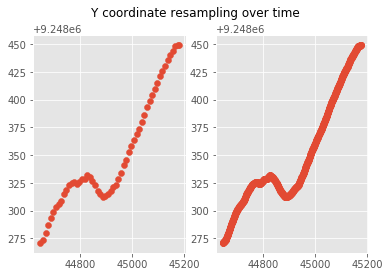

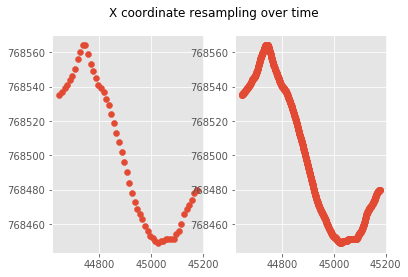

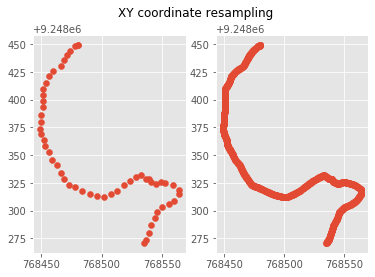

In [420]:
#Before-After resampling plot comparison

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Y coordinate resampling over time')
ax1.scatter(TimeOri,gps['4'])
ax2.scatter(TimeRes,Ynew)

fig, (ax3, ax4) = plt.subplots(1, 2)
fig.suptitle('X coordinate resampling over time')
ax3.scatter(TimeOri,gps['3'])
ax4.scatter(TimeRes,Xnew)

fig, (ax5, ax6) = plt.subplots(1, 2)
fig.suptitle('XY coordinate resampling')
ax5.scatter(gps['3'],gps['4'])
ax6.scatter(Xnew,Ynew)

In [342]:
def plot_segy(file):
    # Load data
    with segyio.open(file, ignore_geometry=True) as f:
        # Get basic attributes
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:]
    # Plot
    plt.style.use('ggplot')  # Use ggplot styles for all plotting
    vm = np.percentile(data, 99)
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    extent = [1, n_traces, twt[-1], twt[0]]  # define extent
    ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
    ax.set_xlabel('CDP number')
    ax.set_ylabel('TWT [ms]')
    ax.set_title(f'{file}')

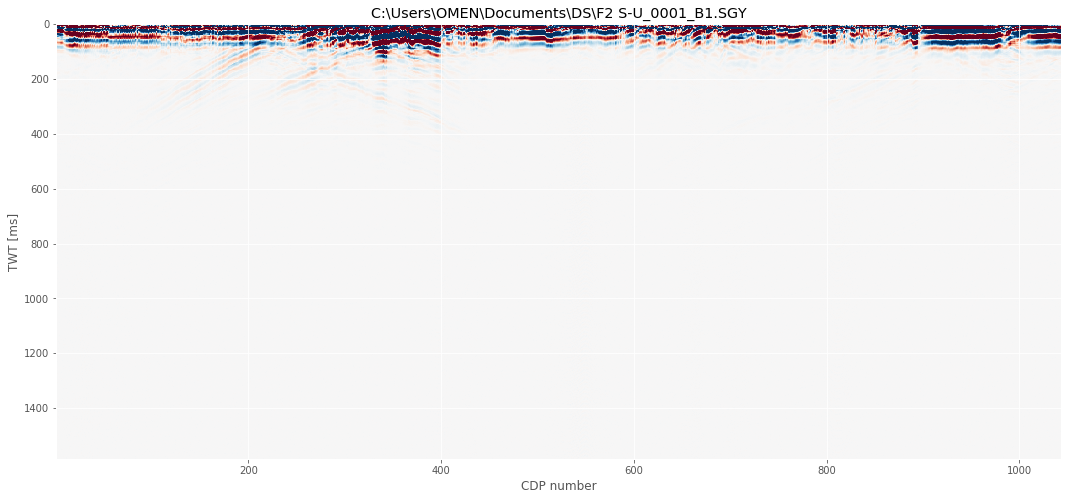

In [343]:
plot_segy(r"C:\Users\OMEN\Documents\DS\F2 S-U_0001_B1.SGY") #If you want to look into segy section

In [486]:
#Overwrite XY process on segy files
scaler=100 #it means XY were multiplied by 100 to catch 2 digit behind comma into integer
sourcex = (Xnew*scaler).astype(int) #Scaled to 0.01
sourcey = (Ynew*scaler).astype(int) #Scaled to 0.01

for i in range( len(f.header) ):
    f.header[i] = {segyio.TraceField.SourceX: sourcex[i], segyio.TraceField.SourceY: sourcey[i], segyio.TraceField.GroupX: sourcex[i], segyio.TraceField.GroupY: sourcey[i], segyio.TraceField.SourceGroupScalar: -scaler}

In [487]:
f.attributes(71)[:] #Inspect scale XY

array([-100, -100, -100, ..., -100, -100, -100], dtype=int32)